In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import cv2 as cv
# from scipy.ndimage.filters import sobel
from scipy.ndimage import sobel
import pathlib
from dotenv import load_dotenv

from ipywidgets import interact, widgets
from plotly.express import imshow as imshow_interactive
from tqdm.notebook import tqdm

**Здесь будет аккуратное оформелние метода с пост-обработкой корреляционной карты, пока оно не готово**

In [3]:
import numpy_indexed as npi

In [4]:
from template_match import read_image_rgb, read_image_gray, template_match, detect_points, find_tolerance_limit, simplify_points, agglomerative_clustering, meanshift_clustering, invert_convolution_map, point_to_bbox
from process_template import template_tresholding

In [5]:
def draw_image(image: np.ndarray) -> None:
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))


def draw_points_on_canvas(points: np.ndarray, image: np.ndarray) -> None:
    x = points[:, 0]
    y = points[:, 1]
    
    clear_canvas = image.copy()
    clear_canvas[:, :] = 255
    plt.scatter(x, y, alpha=0.5, s=5)
    plt.imshow(cv.cvtColor(clear_canvas, cv.COLOR_BGR2RGB))

In [6]:

from matplotlib.patches import Rectangle

def draw_bbox(x_min, x_max, y_min, y_max, bbox_center=None) -> None:
    height = y_max - y_min
    width = x_max - x_min
    rect = Rectangle((x_min, y_min), width, height, edgecolor='r', facecolor='none')
    ax = plt.gca()
    ax.add_patch(rect)

    if bbox_center:
        bbox_center_x, bbox_center_y = bbox_center
        plt.scatter([bbox_center_x], [bbox_center_y], marker="*")

In [7]:
BASE_DIR = pathlib.Path(__name__).resolve().parent.parent
load_dotenv(BASE_DIR / '.env')
DATA_PATH = pathlib.Path(os.getenv("DATA_PATH"))

In [ ]:
def get_image_part(y: int, x: int, image: np.ndarray, w: int, h: int):
    return image[y : y+h, x : x+w]

def sqdiff(image_part: np.ndarray, template: np.ndarray):
    sqdiff_sum = np.sum((image_part.astype(np.float64) - template.astype(np.float64))**2)
    return sqdiff_sum


def compute_mask_pixel_ratio(image_part: np.ndarray, template_mask: np.ndarray, image_mask_value: float):
    image_mask = image_part[:, :, 0]
    image_mask_indexes = np.where(image_mask == image_mask_value)
    template_non_mask_indexes = np.where(template_mask != 0)

    x, y = image_mask_indexes
    image_part_mask_pixel_coords = np.stack((x, y)).T

    x1, y1 = template_non_mask_indexes
    template_non_mask_pixel_coords = np.stack((x1, y1)).T

    true_mask_pixel_coords = npi.intersection(
        image_part_mask_pixel_coords,
        template_non_mask_pixel_coords
    )

    mask_pixel_ratio = len(true_mask_pixel_coords) / len(template_non_mask_pixel_coords)
    
    return mask_pixel_ratio



def sqdiff_normed(image_part: np.ndarray, template: np.ndarray, mask: np.ndarray):
    """
    OpenCV SQDIFF_NORMED implementation
    """
    image_part = image_part.astype(np.float64)
    template = template.astype(np.float64)
    mask = mask.astype(np.float64)

    sqdiff = np.sum( ((template - image_part) * mask)**2 )
    norm1 = np.sum( (template * mask)**2 )
    norm2 = np.sum( (image_part * mask)**2 )

    sqdiff_normed = sqdiff / np.sqrt(norm1 * norm2)

    return sqdiff_normed


def cv_sqdiff_normed(iamge_part: np.ndarray, template: np.ndarray, mask: np.ndarray):

    sqdiff = cv.matchTemplate(iamge_part, template, cv.TM_SQDIFF_NORMED, mask=mask)
    return sqdiff

## Convolution implementation

In [38]:
PLOT_NUMBER = 6
MARKER_NUMBER = 1

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_same_shape" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"

In [39]:
source_image = read_image_rgb(PLOT_PATH)
template_rgb = read_image_rgb(TEMPLATE_PATH)

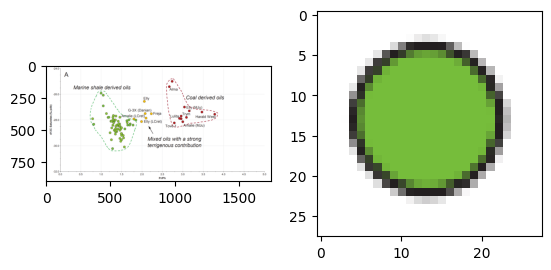

In [40]:
plt.subplot(1, 2, 1)
draw_image(source_image)

plt.subplot(1, 2, 2)
draw_image(template_rgb)

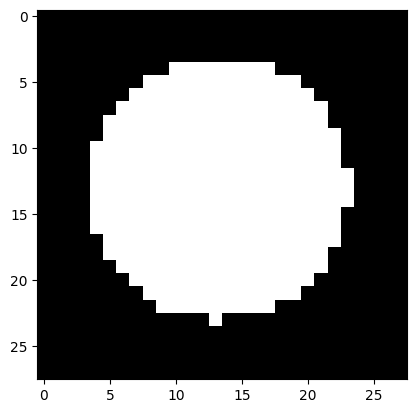

In [ ]:
tresh = 230
template_mask = template_tresholding(template_rgb, treshold=tresh)

draw_image(template_mask)

**Replace black pixels**

In [42]:
image = np.copy(source_image)
template = np.copy(template_rgb)

In [43]:
zero_indexes_image = np.where((image[:, :, 0] == 0) & (image[:, :, 1] == 0) & (image[:, :, 2] == 0))
zero_indexes_template = np.where((template[:, :, 0] == 0) & (template[:, :, 1] == 0) & (template[:, :, 2] == 0))
y_img, x_img = zero_indexes_image
y_tpl, x_tpl = zero_indexes_template

print("Number of black pixels on source image: ", len(zero_indexes_image[0]))
print("Number of black pixels on template: ", len(zero_indexes_template[0]))

Number of black pixels on source image:  0
Number of black pixels on template:  0


In [44]:
image[y_img, x_img, :] = 10
template[y_tpl, x_tpl, :] = 10

**Image tresholding**

In [45]:
# MASK_VALUE = -0.0001
MASK_VALUE = 0

In [46]:
image_mask = template_tresholding(image, treshold=tresh)
indexes_background = np.where(image_mask == 0)
image_with_mask = np.copy(image)
# image_with_mask = image_with_mask.astype(np.float64)  # important step
image_with_mask[indexes_background] = MASK_VALUE

In [48]:
# plt.imshow(image_with_mask)

In [49]:
h_image, w_image = source_image.shape[0], source_image.shape[1]
h_template, w_template = template.shape[0], template.shape[1]

h_image, w_image

(898, 1755)

In [50]:
template_mask_rgb = np.zeros((template_mask.shape[0], template_mask.shape[1], 3))

template_mask_rgb[:, :, 0] = template_mask
template_mask_rgb[:, :, 1] = template_mask
template_mask_rgb[:, :, 2] = template_mask

In [51]:
# method_name = "CUSTOM_SQDIFF"

corr_map_height = h_image - h_template + 1
corr_map_width = w_image - w_template + 1
corr_map0 = np.zeros((corr_map_height, corr_map_width), dtype=np.float64)


for y in tqdm(range(corr_map_height)):
    for x in range(corr_map_width):
        image_part = get_image_part(y, x, image, w_template, h_template)

        # mask_pixel_ratio = compute_mask_pixel_ratio(image_part, mask)
        # if mask_pixel_ratio > 0.7:
        #     corr_map[y, x] = np.nan
        # else:
        #     corr_value = sqdiff_v3(image_part, template, mask_rgb)
        #     corr_map[y, x] = corr_value

        corr_value = sqdiff_normed(image_part, template, template_mask_rgb)
        corr_map0[y, x] = corr_value
        

  0%|          | 0/871 [00:00<?, ?it/s]

In [53]:
corr_map0 = invert_convolution_map(corr_map0)

In [57]:
corr_map = np.copy(corr_map0)

for y in tqdm(range(corr_map_height)):
    for x in range(corr_map_width):
        image_part = get_image_part(y, x, image_with_mask, w_template, h_template)

        mask_pixel_ratio = compute_mask_pixel_ratio(image_part, template_mask, image_mask_value=0)
        if mask_pixel_ratio > 0.5:
            corr_map[y, x] = np.nan

  0%|          | 0/871 [00:00<?, ?it/s]

In [1]:
# imshow_interactive(corr_map, width=800, height=700)